Essential tools for data manipulation, modeling, and visualization.

In [33]:
#Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

We load the dataset and prepare it for modeling by handling missing or inconsistent data.

In [36]:
#Load and preprocess dataset
df = pd.read_csv("data_3dprinter.csv")
df.rename(columns={"tension_strenght": "tensile_strength"}, inplace=True)

#Encode categorical variables
if 'infill_pattern' in df.columns:
    df['infill_pattern'] = df['infill_pattern'].map({'grid': 0, 'honeycomb': 1})
if 'material' in df.columns:
    df['material'] = df['material'].map({'abs': 0, 'pla': 1})
df.drop(columns=['material', 'infill_pattern'], errors='ignore', inplace=True)

We isolate our input features and define the output we want the model to predict.
Model is now ready for performance evaluation.

In [39]:
#Feature and target definition
X = df.drop(columns=['elongation'])
y = df['elongation']

Test various hyperparameter combinations to find the optimal model settings.
This visual checks if predictions align well with actual data.

In [42]:
#Grid search over max_depth and random_state
results = []
for max_depth in range(1, 101):
    for random_state in range(101):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
        model = DecisionTreeRegressor(max_depth=max_depth)
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        r2 = r2_score(y_test, y_test_pred)
        results.append((max_depth, random_state, rmse, r2))

Helps explain which features influence predictions and how.
Using the best-found parameters, we train our Decision Tree model.

Highlights how model sensitivity changes across parameter values.

In [45]:
#Store and select best result
results_df = pd.DataFrame(results, columns=['MaxDepth', 'RandomState', 'RMSE', 'R2'])
best_model = results_df.loc[results_df['RMSE'].idxmin()]
print("\n Best Model Found:")
print(best_model)


 Best Model Found:
MaxDepth       44.000000
RandomState    37.000000
RMSE            0.246982
R2              0.917579
Name: 4380, dtype: float64


The iteration helps to ind the best hyperparameters such as random state and thje depth of the tree. However before proceeding those parameters need to confirmed by the visualisation of their parameters, especially the depth of the tree. This can be found below in the notebook. 

It also helps to see the expected model accuracy using metrics like RMSE and R^2.

In [47]:
#Train final model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=int(best_model['RandomState'])
)
final_model = DecisionTreeRegressor(max_depth=int(best_model['MaxDepth']))
final_model.fit(X_train, y_train)

#Make predictions
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

A scatter plot to help visually compare predicted and actual values.

In [49]:
#Evaluation function
def evaluate_model(y_true, y_pred, dataset_name=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n {dataset_name} Set Evaluation:")
    print(f"MAE: {mae:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")

evaluate_model(y_train, y_train_pred, "Training")
evaluate_model(y_test, y_test_pred, "Testing")


 Training Set Evaluation:
MAE: 0.000
MSE: 0.000
RMSE: 0.000
R²: 1.000

 Testing Set Evaluation:
MAE: 0.280
MSE: 0.110
RMSE: 0.332
R²: 0.851


See how the model makes decisions at each node.

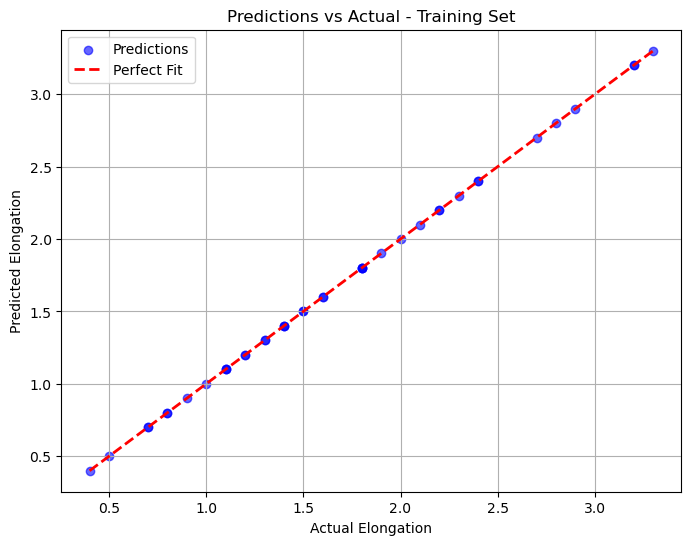

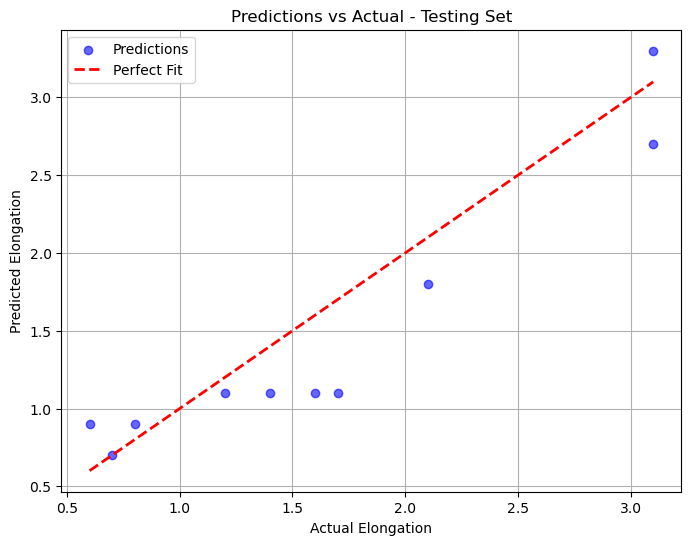

In [51]:
#Prediction plot
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, color='blue', label='Predictions')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Perfect Fit')
    plt.xlabel("Actual Elongation")
    plt.ylabel("Predicted Elongation")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_predictions(y_train, y_train_pred, "Predictions vs Actual - Training Set")
plot_predictions(y_test, y_test_pred, "Predictions vs Actual - Testing Set")

Understand model performance across different hyperparameter configurations.

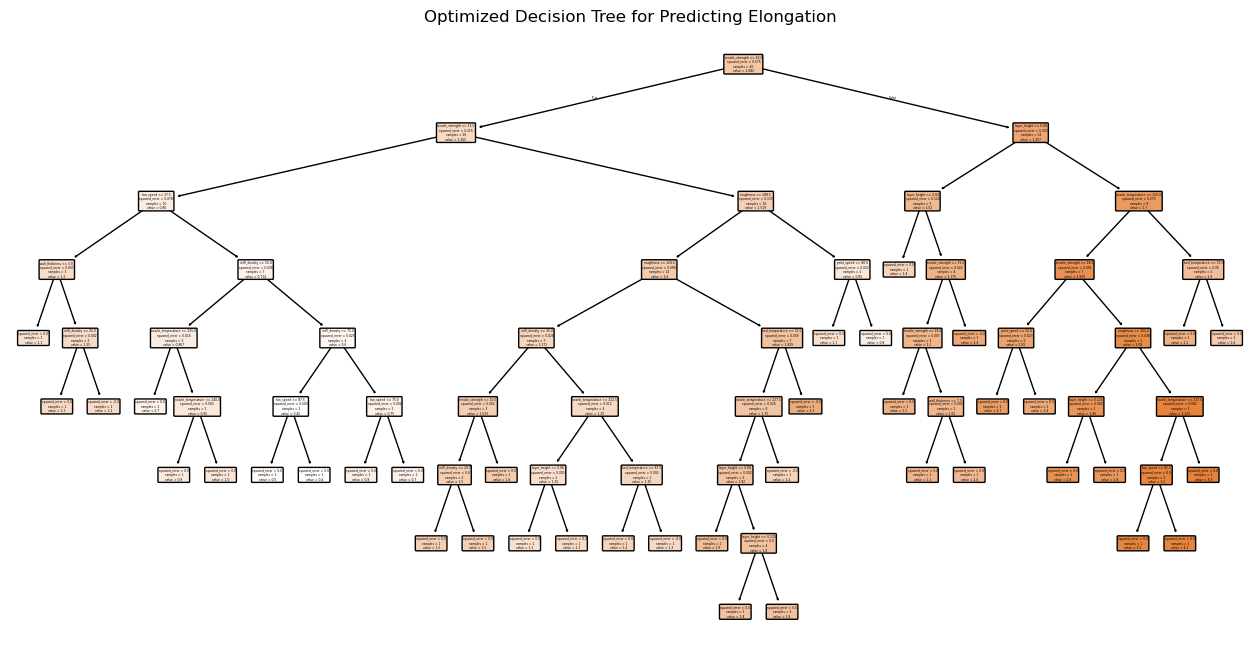

In [53]:
#Visualize the decision tree
plt.figure(figsize=(16, 8))
plot_tree(final_model, feature_names=X.columns, filled=True, rounded=True)
plt.title("Optimized Decision Tree for Predicting Elongation")
plt.show()

Explore how model depth impacts performance.

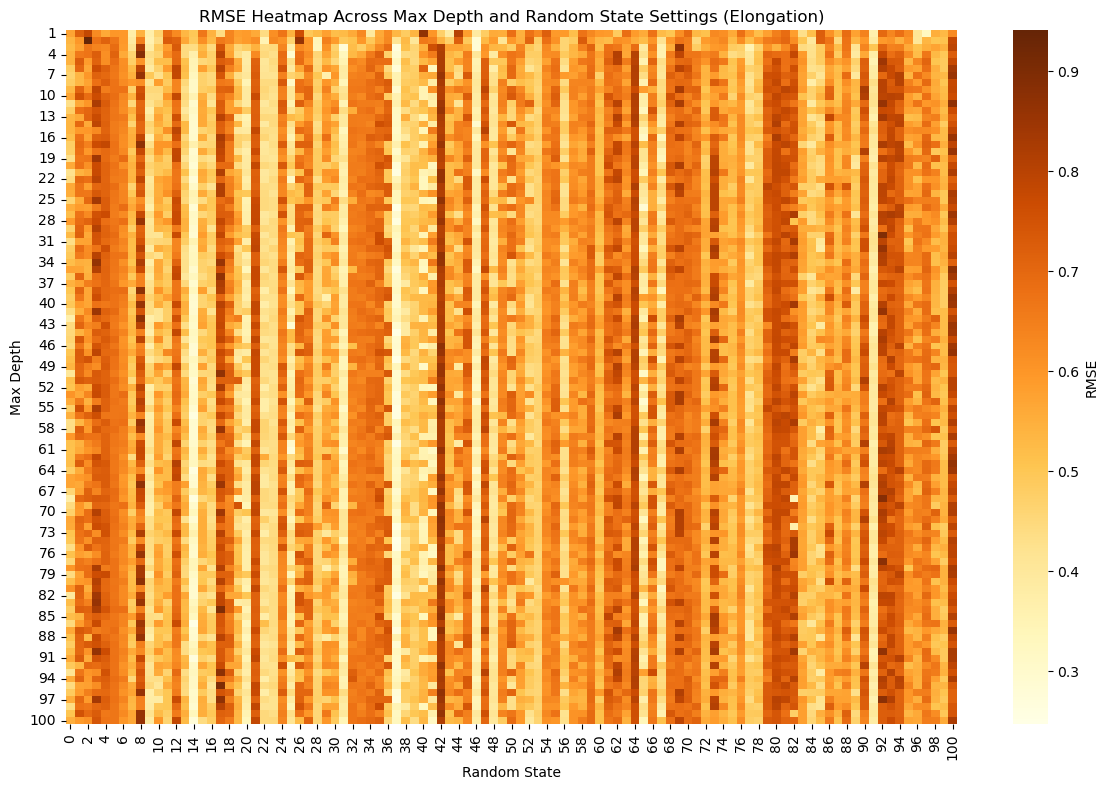

In [55]:
#Heatmap of RMSE
pivot_rmse = results_df.pivot(index='MaxDepth', columns='RandomState', values='RMSE')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_rmse, cmap="YlOrBr", cbar_kws={'label': 'RMSE'})
plt.title("RMSE Heatmap Across Max Depth and Random State Settings (Elongation)")
plt.xlabel("Random State")
plt.ylabel("Max Depth")
plt.tight_layout()
plt.show()

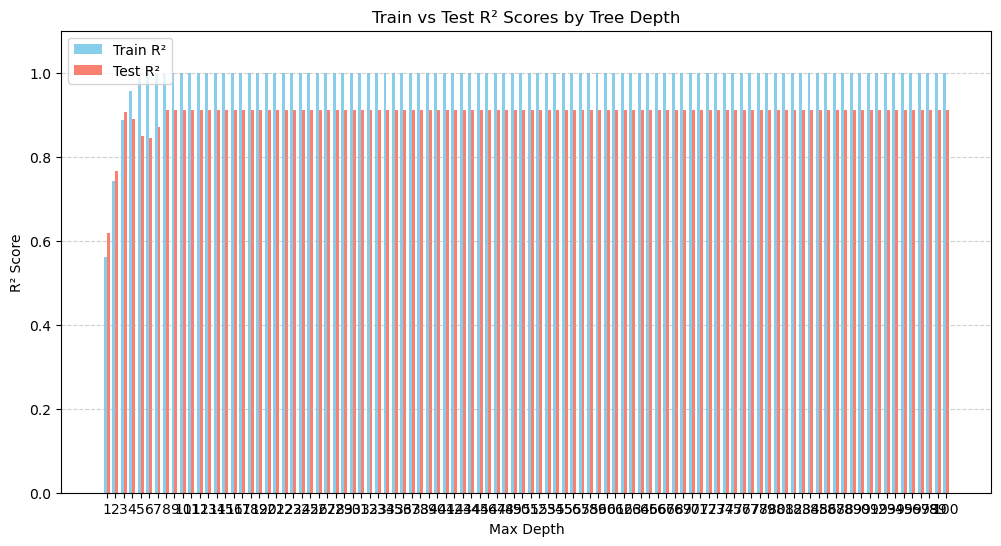

In [56]:
#Define range of depths to test
depths = range(1, 101)
r2_train_scores = []
r2_test_scores = []

#Train and collect R² scores
for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=int(best_model['RandomState']))
    model.fit(X_train, y_train)
    r2_train = r2_score(y_train, model.predict(X_train))
    r2_test = r2_score(y_test, model.predict(X_test))
    r2_train_scores.append(r2_train)
    r2_test_scores.append(r2_test)

#Bar chart visualization
x = np.arange(len(depths))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, r2_train_scores, width, label='Train R²', color='skyblue')
plt.bar(x + width/2, r2_test_scores, width, label='Test R²', color='salmon')

plt.xlabel('Max Depth')
plt.ylabel('R² Score')
plt.title('Train vs Test R² Scores by Tree Depth')
plt.xticks(x, depths)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.show()                                          

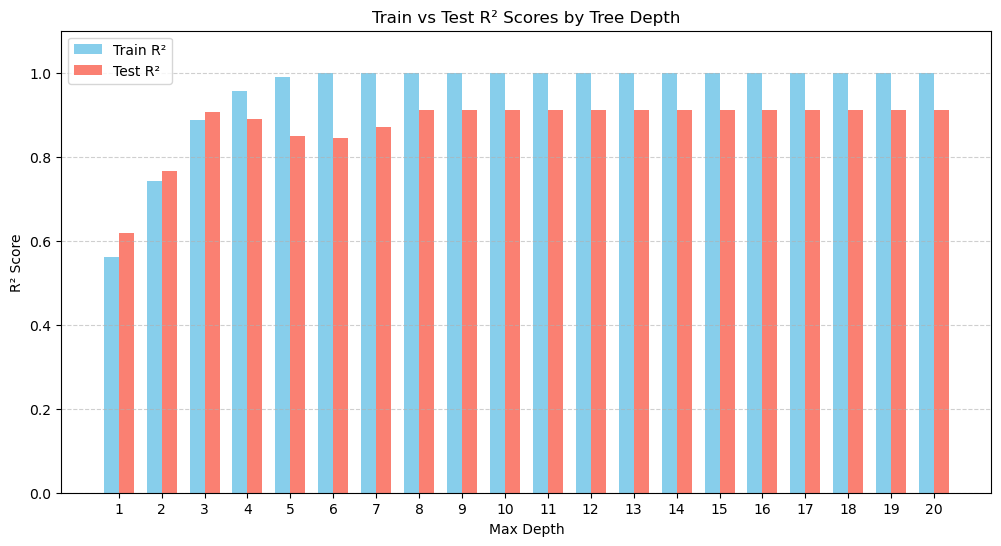

In [57]:
#Define range of depths to test
depths = range(1, 21)
r2_train_scores = []
r2_test_scores = []

#Train and collect R² scores
for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=int(best_model['RandomState']))
    model.fit(X_train, y_train)
    r2_train = r2_score(y_train, model.predict(X_train))
    r2_test = r2_score(y_test, model.predict(X_test))
    r2_train_scores.append(r2_train)
    r2_test_scores.append(r2_test)

#Bar chart visualization
x = np.arange(len(depths))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, r2_train_scores, width, label='Train R²', color='skyblue')
plt.bar(x + width/2, r2_test_scores, width, label='Test R²', color='salmon')

plt.xlabel('Max Depth')
plt.ylabel('R² Score')
plt.title('Train vs Test R² Scores by Tree Depth')
plt.xticks(x, depths)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.show()

Use the best parameters found earlier to build the final model.

The bar chart presents the performance of a Decision Tree Regressor across varying tree depths from 1 to 100, showing both training and testing R² scores. By depth 7, the training R² reaches a perfect score of 1.00 and remains at that level through depth 20. This indicates that the model is fitting the training data extremely well, as it has learnt it, and now strongly overfitting.

However, it is difficult to read the graph. Hence, depths from 1 to 20 has been chosen since approximately this point test R2 remains unchanged.

The training R^2 score starts relatively low at depth 1 (around 0.56) and increases rapidly as the tree depth grows. 

On the other hand, the testing R^2 score shows a different trend. It increases steadily from depth 1 to around depth 6 or 7, where it reaches its highest value, close to 0.95. Beyond that point, the test R^2 begins to level off and shows minimal gains or a slight decline, staying around 0.92 to 0.93. This suggests that increasing tree depth beyond a depth 6 or 7  does not improve model generalization and may, in fact, and only leads to overfitting. Therefore the model shows underfitting for depth 1 and 2 and begins to significatly overfit for depths over 5. 

In summary, while the model becomes increasingly powerful and capable of memorizing training data with greater depth, its ability to generalize to unseen data improves only up to a point.
The best Max Depths is 3 since it has the lowest difference between train and test R^2 without overfitting.

In [60]:
#Use the best random_state identified earlier
best_random_state = int(best_model['RandomState'])

#Train model with max_depth = 3
model_depth_3 = DecisionTreeRegressor(max_depth=3, random_state=best_random_state)
model_depth_3.fit(X_train, y_train)

#Make predictions
y_train_pred = model_depth_3.predict(X_train)
y_test_pred = model_depth_3.predict(X_test)

#Calculate R²
r2_train_depth_3 = r2_score(y_train, y_train_pred)
r2_test_depth_3 = r2_score(y_test, y_test_pred)

#Calculate MAE and RMSE
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

#Display results
print(f"Train R² (Depth 3): {r2_train_depth_3:.4f}")
print(f"Test R²  (Depth 3): {r2_test_depth_3:.4f}")
print(f"Train MAE         : {mae_train:.4f}")
print(f"Test MAE          : {mae_test:.4f}")
print(f"Train RMSE        : {rmse_train:.4f}")
print(f"Test RMSE         : {rmse_test:.4f}")

Train R² (Depth 3): 0.8881
Test R²  (Depth 3): 0.9055
Train MAE         : 0.2036
Test MAE          : 0.2157
Train RMSE        : 0.2537
Test RMSE         : 0.2645


Above the properties of the best tree model for elongation (depth 3, random state 37) was plotted, achieving high accuracy implying that the fit is good. 